In [51]:
from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from catboost import CatBoostClassifier

from torch.utils.tensorboard import SummaryWriter
from clearml import Task, Logger

import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=2024):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

### 3 Начинаем эксперимент

In [4]:
from getpass import getpass
access_key = getpass(prompt="Введите API Access токен: ")
secret_key = getpass(prompt="Введите API Secret токен: ")


In [6]:
%%capture
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=$access_key
%env CLEARML_API_SECRET_KEY=$secret_key

### 4 Подгружаем данные

In [5]:
url = "https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/quickstart_train.csv"
rides_info = pd.read_csv(url)

In [6]:
rides_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [7]:
cat_features = ['model', 'car_type', 'fuel_type']
targets = ['target_class', 'target_reg']
features2drop = ['car_id']
filtered_features = [col for col in rides_info.columns if col not in features2drop + targets]
num_features = [col for col in filtered_features if col not in cat_features]

print('categorical features:', cat_features)
print('numerical features:', num_features)
print('target features:', targets)

for col in cat_features:
    rides_info[col] = rides_info[col].astype(str)

categorical features: ['model', 'car_type', 'fuel_type']
numerical features: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
target features: ['target_class', 'target_reg']


In [8]:
train, test = train_test_split(rides_info, test_size=0.2, random_state=42)
X_train = train[filtered_features]
y_train = train['target_class']

X_test = test[filtered_features]
y_test = test['target_class']

In [10]:
cb_params = {
    "depth": 4,
    "learning_rate": 0.06,
    "loss_function": "MultiClass",
    "custom_metric": ["Recall"],
    # Главная фишка катбуста - работа с категориальными признаками
    "cat_features": cat_features,
    # Регуляризация и ускорение
    "colsample_bylevel": 0.098,
    "subsample": 0.95,
    "l2_leaf_reg": 9,
    "min_data_in_leaf": 243,
    "max_bin": 187,
    "random_strength": 1,
    # Параметры ускорения
    "task_type": "CPU",
    "thread_count": -1,
    "bootstrap_type": "Bernoulli",
    # Важное!
    "random_seed": 2024,
    "early_stopping_rounds": 50,
}

In [12]:
task = Task.init(
    project_name="ClearMl_logging",
    task_name="CatBoost model baseline"
)

ClearML Task: created new task id=41269d01cdc34709b6d79fcdd374b67a
2025-07-17 08:31:38,764 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ad63d2f02fed4f299be26cdc07d5b751/experiments/41269d01cdc34709b6d79fcdd374b67a/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d80b7311550>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d80b7fd60f0>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/events.add_batch
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d80b7fd6720>: Failed to resolve 'api.clear.ml' ([Errno -3] Temporary failure in name resolution)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by

In [13]:
task.add_tags(["catboost", "classification", "baseline"])
logger = Logger.current_logger()

In [14]:
task.connect(cb_params, name="CatBoost basic parameters")

{'depth': 4,
 'learning_rate': 0.06,
 'loss_function': 'MultiClass',
 'custom_metric': ['Recall'],
 'cat_features': ['model', 'car_type', 'fuel_type'],
 'colsample_bylevel': 0.098,
 'subsample': 0.95,
 'l2_leaf_reg': 9,
 'min_data_in_leaf': 243,
 'max_bin': 187,
 'random_strength': 1,
 'task_type': 'CPU',
 'thread_count': -1,
 'bootstrap_type': 'Bernoulli',
 'random_seed': 2024,
 'early_stopping_rounds': 50}

In [16]:
logger.report_table(title="Valid data", series="datasets", table_plot=test)

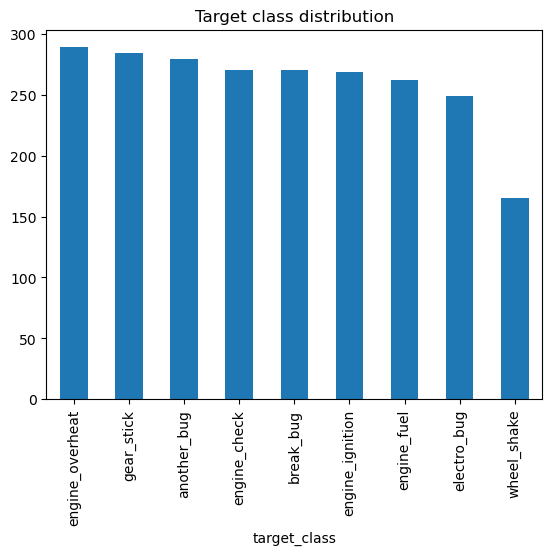

In [52]:
rides_info.target_class.value_counts().plot(kind='bar', title='Target class distribution')
plt.show()

In [ ]:
logger.report_matplotlib_figure(
    title="Target class distribution",
    series="target_class_distribution",
    figure=plt.gcf())

In [19]:
model = CatBoostClassifier(**cb_params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

0:	learn: 2.1707907	test: 2.1735537	best: 2.1735537 (0)	total: 74.3ms	remaining: 1m 14s
100:	learn: 1.1240484	test: 1.1767780	best: 1.1765148 (99)	total: 541ms	remaining: 4.82s
200:	learn: 0.7389912	test: 0.8119925	best: 0.8119925 (200)	total: 1s	remaining: 3.99s
300:	learn: 0.5675196	test: 0.6576350	best: 0.6576350 (300)	total: 1.46s	remaining: 3.39s
400:	learn: 0.4993136	test: 0.6007800	best: 0.6007800 (400)	total: 1.89s	remaining: 2.83s
500:	learn: 0.4626907	test: 0.5792549	best: 0.5792460 (499)	total: 2.29s	remaining: 2.28s
600:	learn: 0.4343711	test: 0.5630634	best: 0.5630634 (600)	total: 2.74s	remaining: 1.82s
700:	learn: 0.4145438	test: 0.5539238	best: 0.5539238 (700)	total: 3.17s	remaining: 1.35s
800:	learn: 0.4031501	test: 0.5495822	best: 0.5491086 (782)	total: 3.62s	remaining: 899ms
900:	learn: 0.3900762	test: 0.5471122	best: 0.5469968 (899)	total: 4.03s	remaining: 442ms
999:	learn: 0.3786618	test: 0.5460318	best: 0.5456753 (967)	total: 4.39s	remaining: 0us

bestTest = 0.5456

In [30]:
model.save_model("catboost_model.cbm", format="cbm")

In [42]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
logger.report_single_value(name='Accuracy', value=accuracy)

In [45]:
cls_report = classification_report(y_test, y_pred, output_dict=True)
cls_report = pd.DataFrame(cls_report).transpose()
cls_report

,precision,recall,f1-score,support
another_bug,0.888889,0.827586,0.857143,58.000000
break_bug,1.000000,1.000000,1.000000,56.000000
electro_bug,1.000000,1.000000,1.000000,51.000000
engine_check,0.727273,0.816327,0.769231,49.000000
engine_fuel,0.720000,0.620690,0.666667,58.000000
engine_ignition,0.700000,0.482759,0.571429,58.000000
engine_overheat,0.443038,0.729167,0.551181,48.000000
gear_stick,0.959184,0.921569,0.940000,51.000000
wheel_shake,0.823529,0.717949,0.767123,39.000000
accuracy,0.788462,0.788462,0.788462,0.788462


In [46]:
logger.report_table(title="Classification Report", series="metrics", table_plot=cls_report)

In [47]:
task.close()

In [ ]:
%%writefile
#!